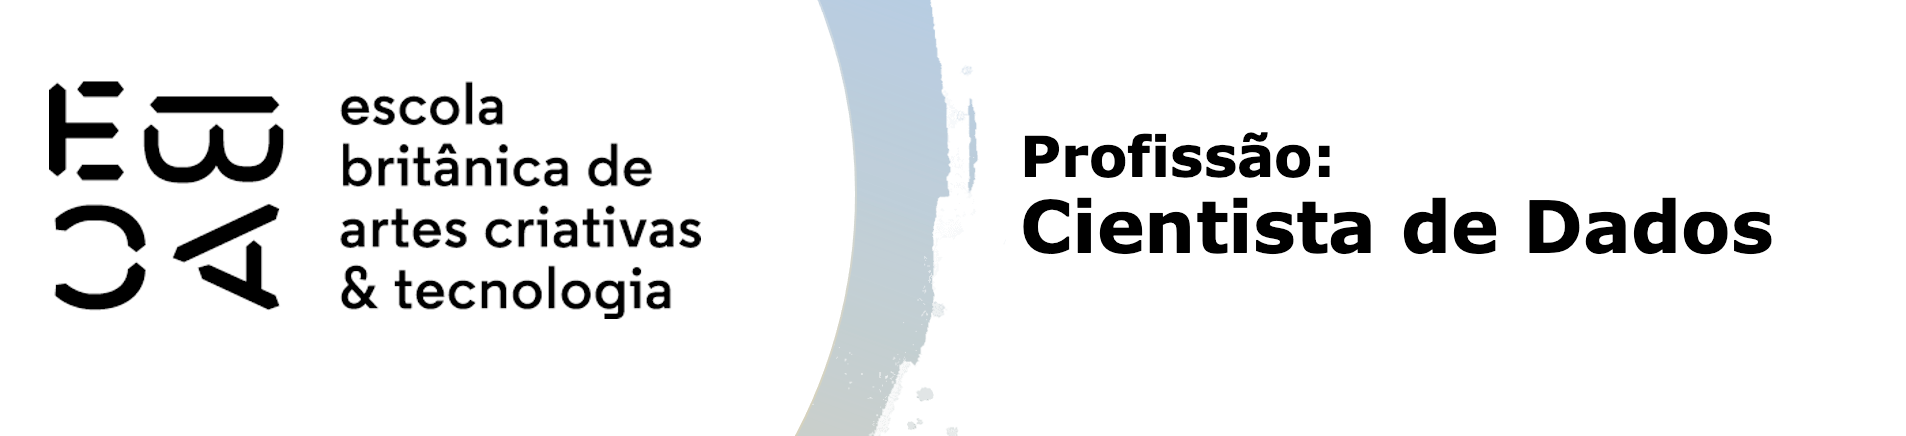

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [5]:
import numpy as np      # Biblioteca para operações matemáticas e manipulação de arrays
import pandas as pd     # Biblioteca para manipulação e análise de dados (DataFrames)
import matplotlib.pyplot as plt  # Biblioteca para criar gráficos
import seaborn as sns            # Biblioteca para visualização de dados mais avançada, integrada ao Matplotlib
import statsmodels.api as sm           # Biblioteca para criar modelos estatísticos
import statsmodels.formula.api as smf  # Interface para criar modelos estatísticos usando fórmulas

from sklearn.model_selection import train_test_split  # Função para dividir os dados em treino e teste
from scipy.interpolate import interp1d  # Função para interpolação de dados (preenchimento de valores)
from sklearn.metrics import r2_score  # Função para calcular o coeficiente de determinação (R²), avaliando a qualidade do modelo
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif  # Função para calcular o Fator de Inflação da Variância (VIF), usada para detectar multicolinearidade entre variáveis

In [6]:
df = pd.read_csv('previsao_de_renda_II.csv')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [7]:
df.fillna(value={"tempo_emprego": df.tempo_emprego.mean()}, inplace=True)
df['log_renda'] = np.log(df['renda'])
df.isna().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
log_renda                0
dtype: int64

In [8]:
def amostra(
    data: pd.DataFrame, 
    column: str, 
    perc: float = 1, 
    seed: int = None, 
    test_size: float = 0.2, 
    random_state: int = None
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Retorna uma amostra de um DataFrame agrupada por uma coluna específica e divide os dados em treino e teste.
    Além disso, salva a amostra em uma variável global 'df_sample'.

    Parâmetros:
    - data (pd.DataFrame): O DataFrame a ser processado.
    - column (str): Nome da coluna usada para agrupar os dados antes de amostrar.
    - perc (float): Porcentagem de amostragem sobre os dados agrupados (entre 0 e 1). Default: 1 (100% dos dados).
    - seed (int, optional): Semente para amostragem dentro dos grupos. Default: None.
    - test_size (float): Proporção da base de teste no conjunto final (entre 0 e 1). Default: 0.2 (20% dos dados).
    - random_state (int, optional): Semente para divisão treino-teste. Default: None.

    Retorno:
    - tuple[pd.DataFrame, pd.DataFrame]: Dois DataFrames (treino, teste) com base na divisão.

    Erros:
    - ValueError: Se `perc` ou `test_size` não estiverem entre 0 e 1.
    - KeyError: Se a coluna especificada não existir no DataFrame.

    Exemplo:
    >>> df = pd.DataFrame({'grupo': ['A', 'A', 'B', 'B'], 'valor': [10, 20, 30, 40]})
    >>> train, test = amostra(df, column='grupo', perc=0.5, test_size=0.3, random_state=42)
    """
    global df_sample  # Torna a variável acessível globalmente

    # Validações
    if not (0 < perc <= 1):
        raise ValueError("O parâmetro 'perc' deve estar entre 0 e 1.")
    if not (0 < test_size < 1):
        raise ValueError("O parâmetro 'test_size' deve estar entre 0 e 1.")
    if column not in data.columns:
        raise KeyError(f"A coluna '{column}' não existe no DataFrame.")

    # Amostra agrupada por coluna com fração especificada
    df_sample = (
        data.groupby(column, group_keys=False)
        .apply(lambda x: x.sample(frac=perc, random_state=seed))
    )

    # Divisão em treino e teste
    train, test = train_test_split(
        df_sample, 
        test_size=test_size, 
        random_state=random_state
    )
    
    # Resumo das dimensões
    print(f"Tamanho da amostra (df_sample): {len(df_sample)} linhas.")
    print(f"Divisão: {len(train)} linhas no treino e {len(test)} linhas no teste.")
    
    return train.reset_index(drop=True), test.reset_index(drop=True)


In [9]:
df_train, df_test = amostra(df, column='data_ref', perc=.02, seed=450, test_size=0.3, random_state=1280)

print("Treino:")
print(df_train)
print("\nTeste:")
print(df_test)

Tamanho da amostra (df_sample): 15000 linhas.
Divisão: 10500 linhas no treino e 4500 linhas no teste.
Treino:
         data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0      2016-02-01  15285    F                S               N           0   
1      2015-06-01    481    M                S               S           0   
2      2015-06-01  10942    F                N               N           0   
3      2015-01-01   6698    M                N               S           1   
4      2015-01-01   2515    F                N               S           0   
...           ...    ...  ...              ...             ...         ...   
10495  2015-05-01    372    M                S               N           0   
10496  2015-12-01  16000    F                N               S           0   
10497  2015-02-01    675    M                S               S           0   
10498  2015-12-01   3704    M                S               N           0   
10499  2015-02-01   2425    F   

In [10]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 33708 to 732798
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   data_ref               15000 non-null  object 
 1   index                  15000 non-null  int64  
 2   sexo                   15000 non-null  object 
 3   posse_de_veiculo       15000 non-null  object 
 4   posse_de_imovel        15000 non-null  object 
 5   qtd_filhos             15000 non-null  int64  
 6   tipo_renda             15000 non-null  object 
 7   educacao               15000 non-null  object 
 8   estado_civil           15000 non-null  object 
 9   tipo_residencia        15000 non-null  object 
 10  idade                  15000 non-null  int64  
 11  tempo_emprego          15000 non-null  float64
 12  qt_pessoas_residencia  15000 non-null  float64
 13  renda                  15000 non-null  float64
 14  log_renda              15000 non-null  float64
dt

                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     6310.
Date:                Tue, 26 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:25:26   Log-Likelihood:                -15032.
No. Observations:               10500   AIC:                         3.007e+04
Df Residuals:                   10498   BIC:                         3.008e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.0313      0.016    499.463

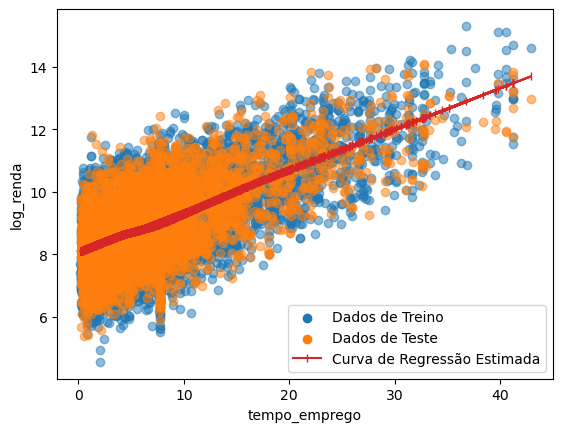

In [11]:
# Ajustando o modelo de regressão
model = smf.ols(formula="log_renda ~ tempo_emprego", data=df_train).fit()

# Resumo do modelo
print(model.summary())

# Previsões
predicts = model.predict(df_train['tempo_emprego'])
residuals = model.resid

# Aplicando LOWESS
lowess = sm.nonparametric.lowess(endog=df_train.log_renda, exog=df_train.tempo_emprego)
interpid =interp1d(x=lowess[:,0],y=lowess[:,1], bounds_error=False)
# smoothed = lowess(df_train['log_renda'], df_train['tempo_emprego'], frac=0.3)  # `frac` controla a suavização

# Adicionando a coluna 'lowess' aos DataFrames de treino e teste com os valores ajustados pela função de interpolação
df_train["lowess"] = interpid(df_train.tempo_emprego)
df_test["lowess"] = interpid(df_test.tempo_emprego)

# Exibindo o resumo do modelo ajustado para avaliar os resultados
reg_lowess = smf.ols(formula="log_renda ~ lowess", data=df_train).fit()
print(reg_lowess.summary())

# Obtendo as cores padrão para os gráficos a partir das configurações do Matplotlib
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Criando um gráfico de dispersão para os dados de treino
plt.scatter(x=df_train.tempo_emprego, y=df_train.log_renda, color=colors[0], alpha=.5)
plt.scatter([], [], color=colors[0], label="Dados de Treino")  # Adicionando uma entrada na legenda para os dados de treino

# Criando um gráfico de dispersão para os dados de teste
plt.scatter(x=df_test.tempo_emprego, y=df_test.log_renda, color=colors[1], alpha=.5)
plt.scatter([], [], color=colors[1], label="Dados de Teste")  # Adicionando uma entrada na legenda para os dados de teste

# Adicionando a curva de regressão estimada para os dados de teste
plt.plot(df_test.tempo_emprego, reg_lowess.predict(df_test), "|-", color=colors[3], label="Curva de Regressão Estimada")

# Adicionando rótulos aos eixos
plt.xlabel("tempo_emprego")
plt.ylabel("log_renda")

# Exibindo a legenda e o gráfico
plt.legend()
plt.show()


In [12]:
# Utilizando o método r2_score para comparar os valores reais (y_true) com as previsões do modelo (y_pred)
print("{:.2%}".format(r2_score(y_true=df_test.log_renda, y_pred=reg_lowess.predict(df_test))))

36.98%


## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

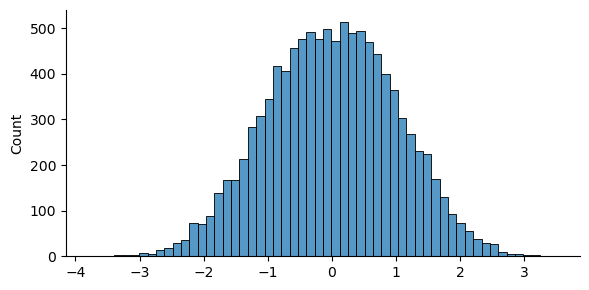

In [15]:
# criando um histograma com os residuos do modelo de regressão
# 'reg.resid' contém os resíduos (diferença entre os valores reais e os valores previstos pelo modelo)
sns.displot(data=reg_lowess.resid, height=3, aspect=2)

plt.show()

O histograma mostra resíduos simétricos e centrados em zero, sugerindo que o modelo está bem ajustado e sem viés. A forma lembra uma distribuição normal, o que é positivo

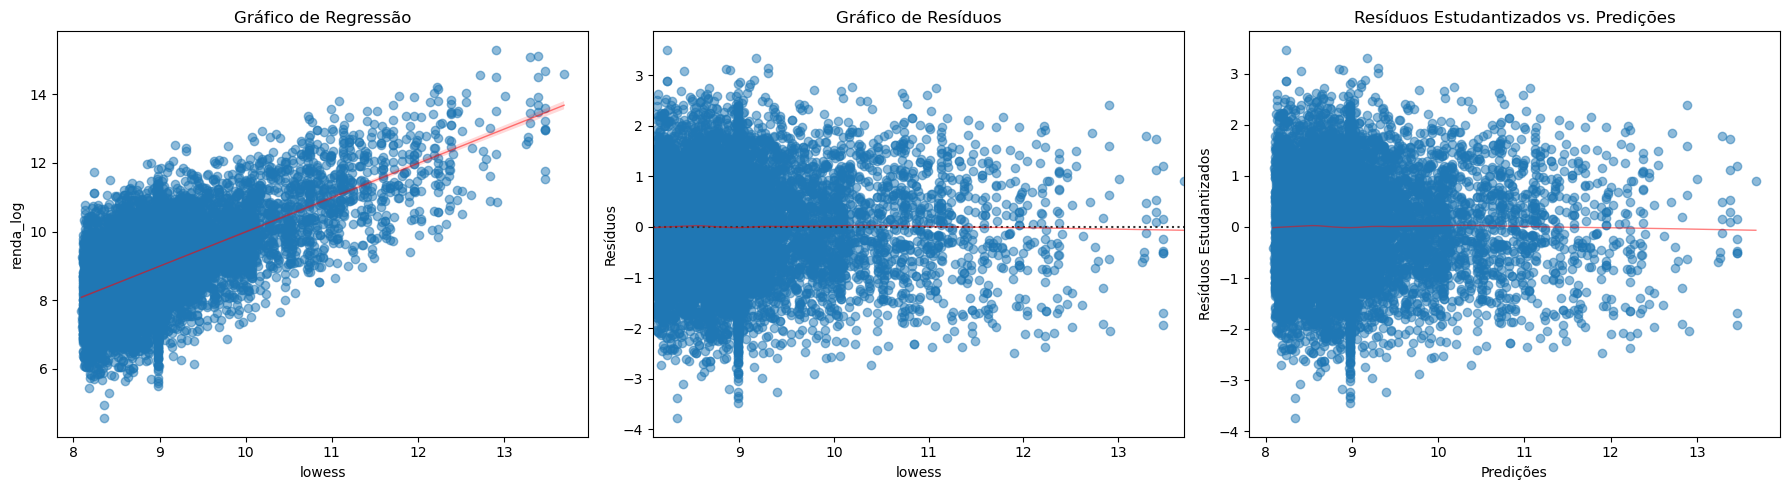

In [24]:
#Verificando a suposição de independência dos resíduos através de: 
# Gráfico de Regressão, Gráfico de Resíduos e Gráfico de Resíduos Estudantizados vs. Predições

fig, ax = plt.subplots(ncols=3, figsize=(18,5))

# Gráfico de Regressão entre 'lowess' e 'renda_log'
sns.regplot(ax=ax[0],
            data=df_train, 
            x='lowess',
            y='log_renda',
            scatter_kws={'alpha':.5},
            line_kws={'color':'red','lw':1,'alpha':.5})

ax[0].set_title("Gráfico de Regressão")
ax[0].set_xlabel("lowess")
ax[0].set_ylabel("renda_log")

# Gráfico de Resíduos entre 'lowess' e 'renda_log'
sns.residplot(ax=ax[1],
              data=df_train, 
              x='lowess',
              y='log_renda',
              scatter_kws={'alpha':.5},
              line_kws={'color':'red','lw':1,'alpha':.5},
              lowess=True)


ax[1].set_title("Gráfico de Resíduos")
ax[1].set_xlabel("lowess")
ax[1].set_ylabel("Resíduos")

# Gráfico de Resíduos Estudantizados vs. Predições
sns.regplot(ax=ax[2],
              data=df_train, 
              x=reg_lowess.predict(),
              y=reg_lowess.outlier_test().student_resid,
              scatter_kws={'alpha':.5},
              line_kws={'color':'red','lw':1,'alpha':.5},
              lowess=True)

ax[2].set_title("Resíduos Estudantizados vs. Predições")
ax[2].set_xlabel("Predições")
ax[2].set_ylabel("Resíduos Estudantizados")

plt.tight_layout()
plt.show()

In [26]:
# regressão linear multipla
reg_multi = smf.ols(formula="log_renda ~ lowess + tipo_renda + posse_de_imovel", data=df_train).fit()

reg_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     1119.
Date:                Tue, 26 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:37:34   Log-Likelihood:                -14907.
No. Observations:               10500   AIC:                         2.983e+04
Df Residuals:                   10493   BIC:                         2.988e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.1008      0.115     -0.873      0.382      -0.327       0.125
tipo_renda[T.Bolsista]             0.7067      0.578      1.222      0.222      -0.427       1.840
tipo_renda[T.Empresário]           0.1219      0.025      4.944      0.000       0.074       0.170
tipo_renda[T.Pensionista]         -0.1754      0.027     -6.423      0.000      -0.229      -0.122
tipo_renda[T.Servidor público]     0.1479      0.037      4.016      0.000       0.076       0.220
posse_de_imovel[T.S]               0.2187      0.021     10.450      0.000       0.178       0.260
lowess                             0.9929      0.013     78.936      0.000       0.968       1.018
==============================================================================
Omnibus:                       52.553   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.530
Skew:                          -0.045   Prob(JB):                     2.61e-09
Kurtosis:                       2.713   Cond. No.                         542.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
# Realizando um teste de identificação de outliers no modelo ajustado
outlier_test = reg_multi.outlier_test()

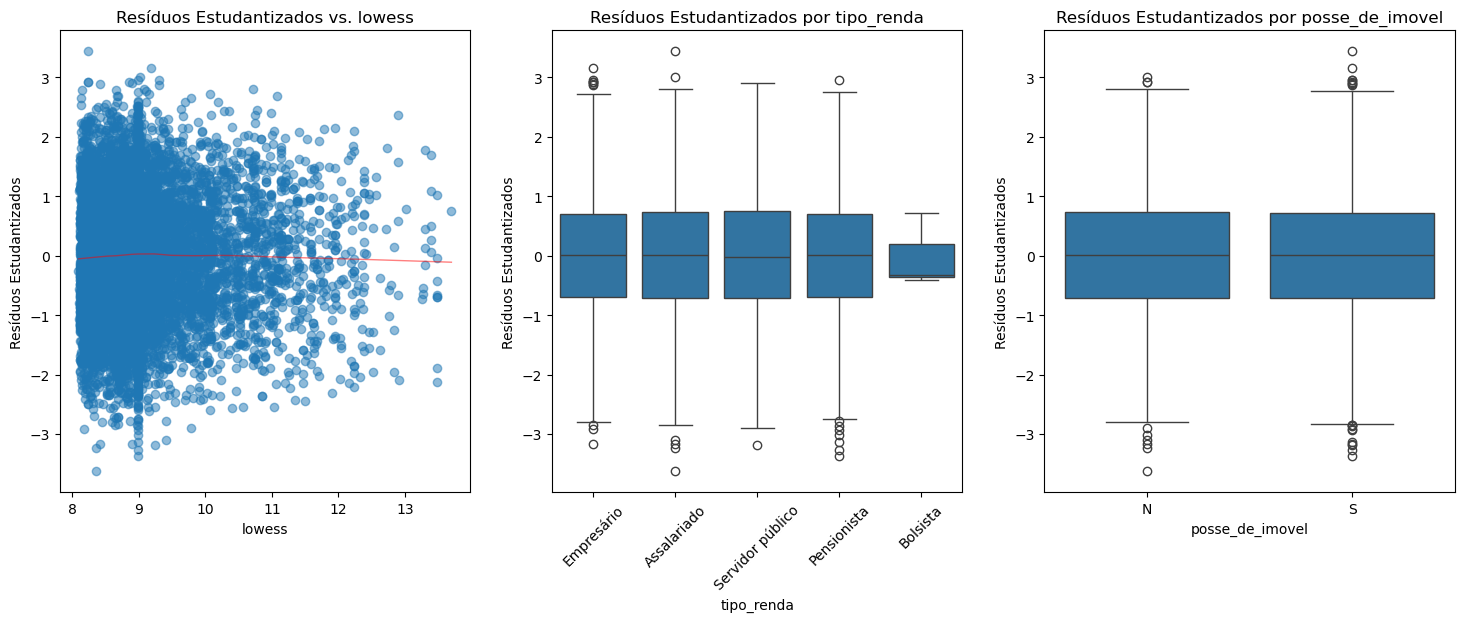

In [30]:
# Criando três gráficos para analisar os resíduos estudantizados em relação às diferentes variáveis do modelo de regressão múltipla

fig, ax = plt.subplots(ncols=3, figsize=(18,6))

# Gráfico de Dispersão: Resíduos Estudantizados vs. 'lowess'
sns.regplot(ax=ax[0], x=df_train.lowess, y=outlier_test.student_resid, lowess=True, 
            scatter_kws={"alpha":.5}, line_kws={"color":"red", "lw":1, "alpha":.5})

ax[0].set_title("Resíduos Estudantizados vs. lowess")
ax[0].set_xlabel("lowess")
ax[0].set_ylabel("Resíduos Estudantizados")

# Gráfico de Boxplot: Resíduos Estudantizados por 'tipo_renda'
sns.boxplot(ax=ax[1], x=df_train.tipo_renda, y=outlier_test.student_resid)
ax[1].set_title("Resíduos Estudantizados por tipo_renda")
ax[1].set_xlabel("tipo_renda")
ax[1].set_ylabel("Resíduos Estudantizados")
ax[1].tick_params(axis="x", rotation=45)   

# Gráfico de Boxplot: Resíduos Estudantizados por 'posse_de_imovel'
sns.boxplot(ax=ax[2], x=df_train.posse_de_imovel, y=outlier_test.student_resid)
ax[2].set_title("Resíduos Estudantizados por posse_de_imovel")
ax[2].set_xlabel("posse_de_imovel")
ax[2].set_ylabel("Resíduos Estudantizados")

plt.show()

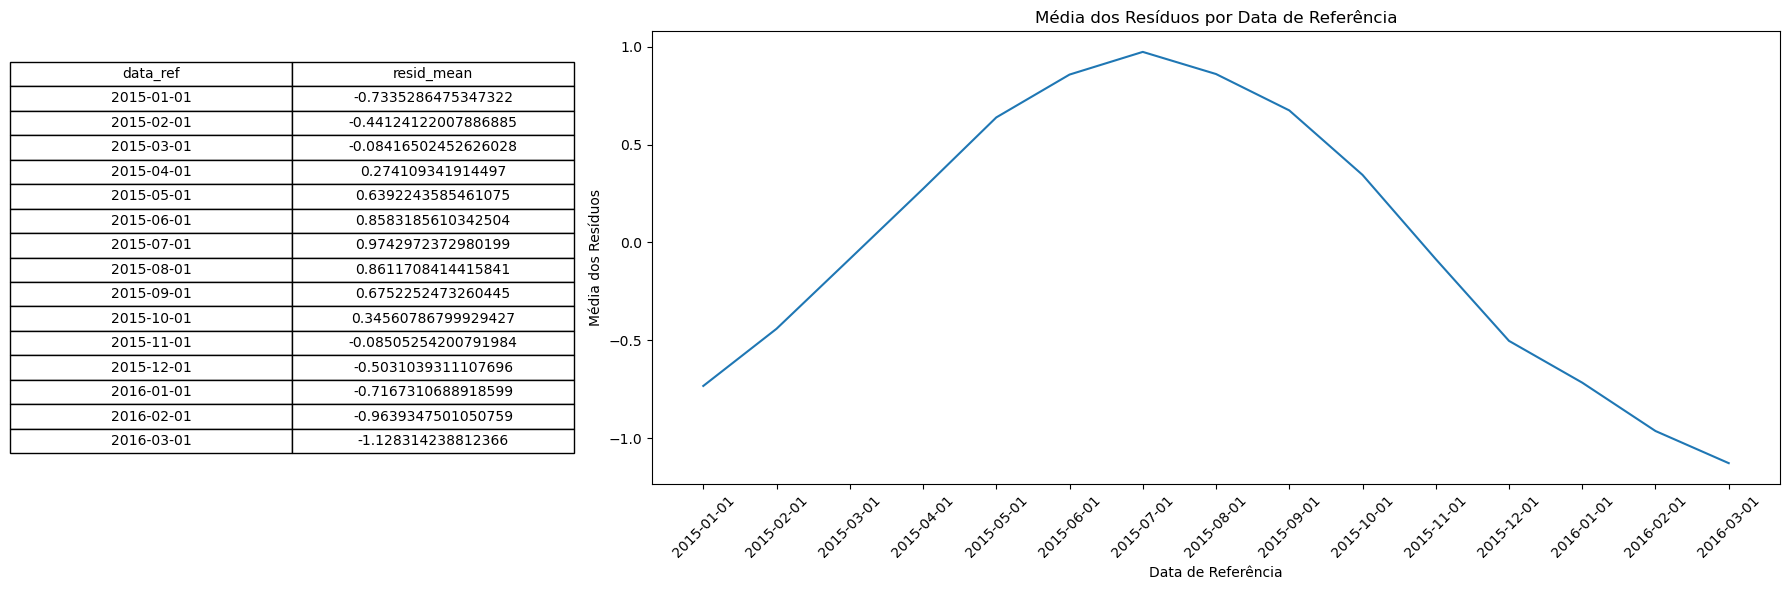

In [32]:
# Avaliando se o valor médio dos resíduos aparenta ter relação com o mês de referência

# Merge para criar o DataFrame df_resid com os resíduos associados à data de referência
df_resid = pd.merge(left=df_train[["data_ref"]], right=pd.Series(data=reg_multi.resid, name="resid"), left_index=True, right_index=True, how="left")

# Preparar os dados para a tabela: calcular a média dos resíduos por data de referência
df_resid_mean = df_resid.groupby(by="data_ref")["resid"].mean().reset_index().rename(columns={"resid":"resid_mean"})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={"width_ratios": [1, 2]})

# Exibir a tabela de médias dos resíduos à esquerda
ax1.axis("off")   
table = ax1.table(cellText=df_resid_mean.values, colLabels=df_resid_mean.columns, cellLoc="center", loc="center")
table.scale(1,1.5)   
table.auto_set_font_size(False)
table.set_fontsize(10)

# Criar o gráfico de linha à direita para mostrar a média dos resíduos ao longo do tempo
sns.lineplot(data=df_resid_mean, x="data_ref", y="resid_mean", ax=ax2)
ax2.set_title("Média dos Resíduos por Data de Referência")
ax2.set_xlabel("Data de Referência")
ax2.set_ylabel("Média dos Resíduos")
plt.xticks(rotation=45)   

plt.tight_layout()
plt.show()

>- O gráfico mostra que a média dos resíduos varia ao longo do tempo, indicando que o modelo pode não estar capturando bem padrões sazonais ou tendências temporais nos dados. Essa falta de independência temporal nos resíduos sugere a necessidade de ajustar o modelo para incorporar esses efeitos.

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

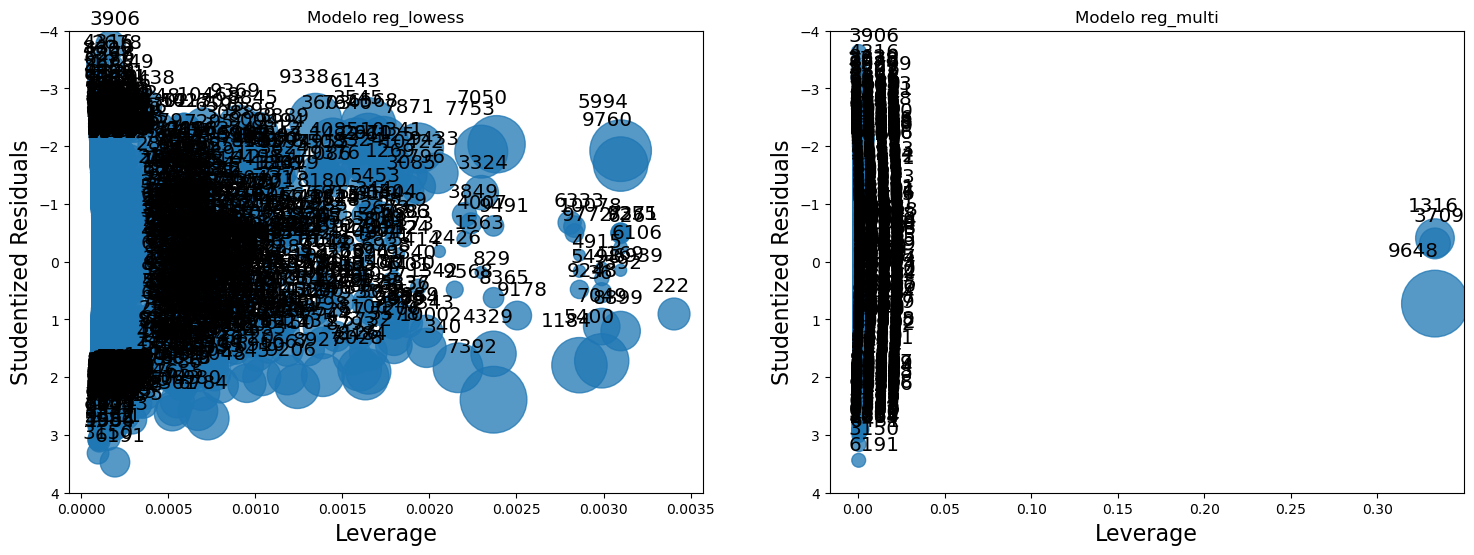

In [35]:
# Avaliando os resíduos estudantizados e identificando pontos discrepantes ou influentes

# Criando dois gráficos para analisar a influência dos pontos no modelo de regressão
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))

# Gráfico de influência para o modelo de regressão 'reg', usando o critério de Cook's Distance
sm.graphics.influence_plot(results=reg_lowess, criterion="cooks", ax=ax[0])
ax[0].set_title("Modelo reg_lowess")
# Ajustando os limites do eixo y para alinhar com a escala dos resíduos estudantizados internos
ax[0].set_ylim(np.ceil(np.max(reg_lowess.get_influence().resid_studentized_internal)), np.floor(np.min(reg_lowess.get_influence().resid_studentized_internal)))

# Gráfico de influência para o modelo 'reg_multi', usando o critério de Cook's Distance
sm.graphics.influence_plot(results=reg_multi, criterion="cooks", ax=ax[1])
ax[1].set_title("Modelo reg_multi")
# Ajustando os limites do eixo y para alinhar com a escala dos resíduos estudantizados internos
ax[1].set_ylim(np.ceil(np.max(reg_multi.get_influence().resid_studentized_internal)), np.floor(np.min(reg_multi.get_influence().resid_studentized_internal)))

# Exibindo os gráficos
plt.show()

In [37]:
# Exibindo a contagem de observações para cada combinação de 'tipo_renda' e 'posse_de_imovel' no DataFrame de treino
# Isso ajuda a entender a distribuição das observações por essas categorias
display(df_train.groupby(["tipo_renda", "posse_de_imovel"]).size().to_frame(name="qtd"))

# Calculando a alavancagem (leverage) para cada observação com base no modelo de regressão múltipla
# A alavancagem mede o impacto potencial de cada observação na estimativa dos parâmetros do modelo
df_train["leverage"] = reg_multi.get_influence().hat_matrix_diag

# Exibindo as observações com alavancagem maior que 0.2
# Essas observações têm um impacto potencialmente alto na estimação dos parâmetros do modelo
display(df_train[df_train.leverage > .2])

# Exibindo a contagem de observações com alta alavancagem para cada combinação de 'tipo_renda' e 'posse_de_imovel'
# Isso fornece uma visão detalhada da distribuição das observações com alta alavancagem por categoria
display(df_train[df_train.leverage > .2].groupby(by=["tipo_renda", "posse_de_imovel"]).size().to_frame("qtd"))

qtd
tipo_renda       posse_de_imovel      
Assalariado      N                1932
                 S                3484
Bolsista         S                   3
Empresário       N                 796
                 S                1595
Pensionista      N                 407
                 S                1409
Servidor público N                 306
                 S                 568

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,log_renda,lowess,leverage
1316,2015-08-01,592,F,N,S,0,Bolsista,Superior completo,Casado,Casa,51,10.69589,2.0,18569.34,9.829267,9.40516,0.333333
3709,2015-03-01,597,F,N,S,0,Bolsista,Superior completo,Casado,Casa,51,10.69589,2.0,20012.80,9.904127,9.40516,0.333333
9648,2015-10-01,596,F,N,S,0,Bolsista,Superior completo,Casado,Casa,51,10.69589,2.0,46908.18,10.755947,9.40516,0.333333


,,qtd
tipo_renda,posse_de_imovel,
Bolsista,S,3


In [39]:

# Filtrando os dados para remover as observações onde 'tipo_renda' é igual a 'Bolsista'
# Cria cópias dos DataFrames de treino e teste sem as observações de 'Bolsista'
df_train = df_train[df_train["tipo_renda"] != "Bolsista"].copy()
df_test = df_test[df_test["tipo_renda"] != "Bolsista"].copy()

# Calculando os resíduos estudantizados para o DataFrame de treino com base no modelo 'reg_multi'
df_train["student_resid"] = outlier_test.student_resid

# Filtrando os dados para remover observações com resíduos estudantizados fora do intervalo [-2, 2]
# Isso ajuda a eliminar possíveis outliers
df_train = df_train[(df_train["student_resid"] < 2) & (df_train["student_resid"] > -2)]

# Exibindo as dimensões dos DataFrames de treino e teste após a filtragem
print(df_train.shape)  
print(df_test.shape)   

(10075, 18)
(4497, 16)


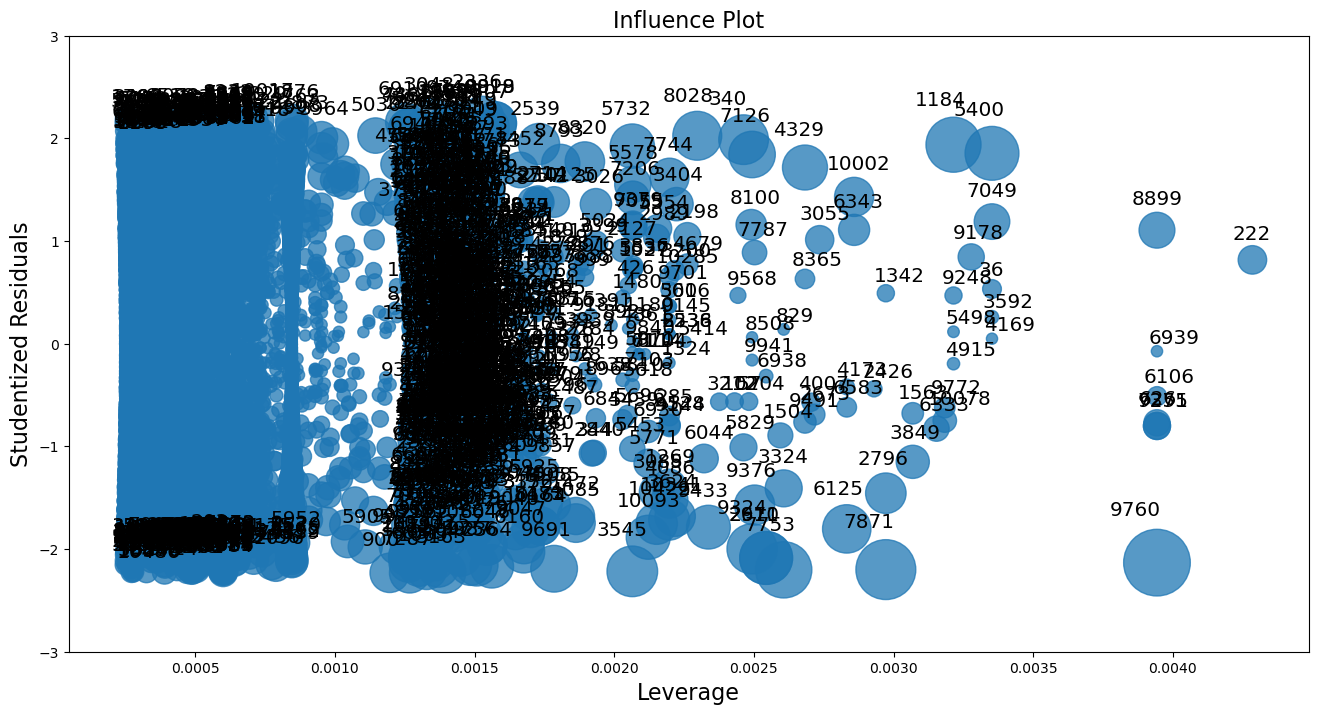

In [41]:
# Criando um gráfico para analisar a influência dos pontos no modelo de regressão múltipla
fig, ax = plt.subplots(figsize=(16,8))

# Criando o gráfico de influência para o modelo de regressão múltipla utilizando o critério de Cook's Distance para identificar pontos discrepantes ou influentes
# Os dados utilizados são do DataFrame de treino após a filtragem
sm.graphics.influence_plot(results=smf.ols(formula="log_renda ~ lowess + tipo_renda + posse_de_imovel", data=df_train).fit(), criterion="cooks", ax=ax)

# Ajustando os limites do eixo y para focar na faixa de influência de -3 a 3
plt.ylim(-3, 3)

plt.show()

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

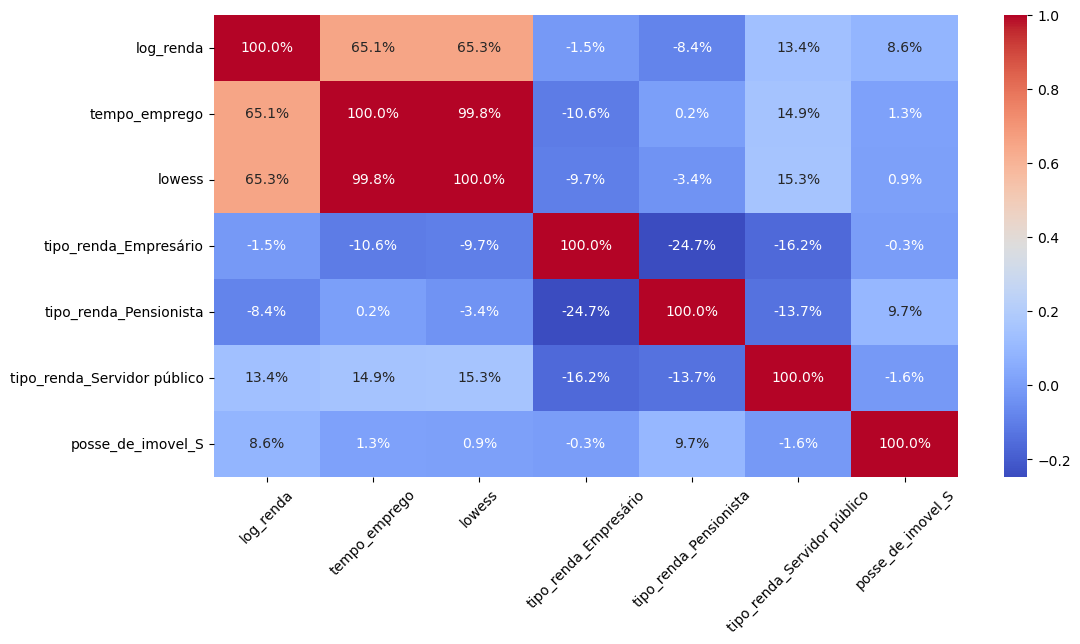

In [47]:
# Criando a matriz de correlação de Pearson para variáveis selecionadas

plt.figure(figsize=(12, 6)) 

# Calcula a correlação de Pearson entre as variáveis selecionadas
sns.heatmap(pd.get_dummies(data=df_train[["log_renda", "tempo_emprego", "lowess", "tipo_renda", "posse_de_imovel"]], drop_first=True).corr(method="pearson"),
            annot=True,   
            fmt=".1%",  
            cmap="coolwarm")  

# Rotaciona os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45)

plt.show()

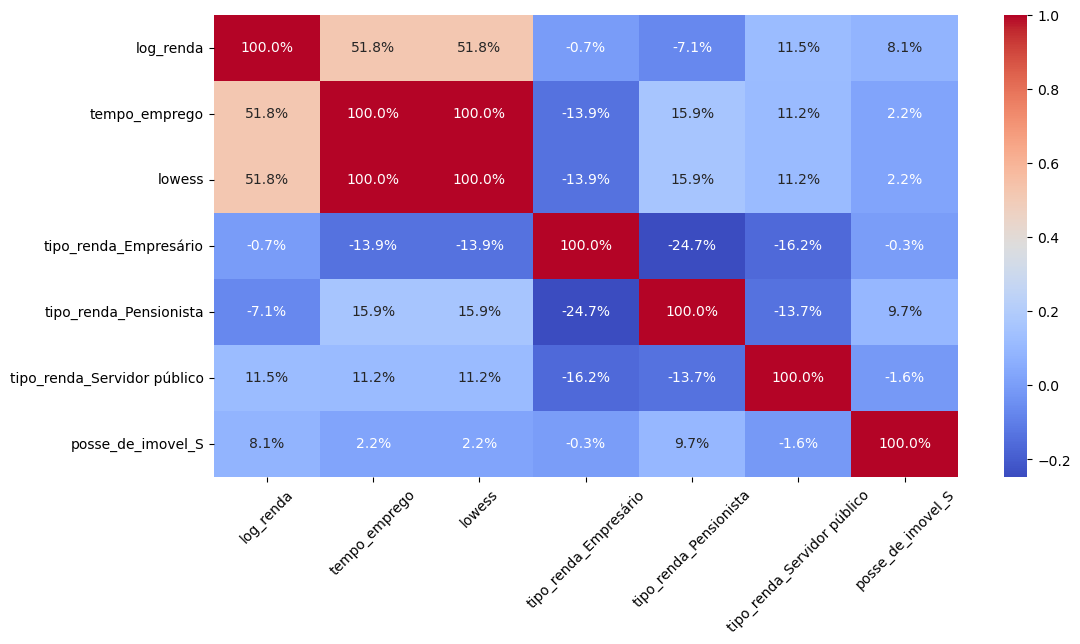

In [45]:
# Criando a matriz de correlação de Spearman para variáveis selecionadas

plt.figure(figsize=(12, 6)) 

# Calcula a correlação de Spearman entre as variáveis selecionadas
sns.heatmap(pd.get_dummies(data=df_train[["log_renda", "tempo_emprego", "lowess", "tipo_renda", "posse_de_imovel"]], drop_first=True).corr(method="spearman"),
            annot=True,   
            fmt=".1%",   
            cmap="coolwarm")  

# Rotaciona os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45)

# Exibe o gráfico de calor (heatmap) com a matriz de correlação de Spearman
plt.show()

In [51]:
# Calculando o Fator de Inflação da Variância (VIF) para detectar multicolinearidade

# Definindo as colunas para as quais o VIF será calculado
columns = ["tempo_emprego", "posse_de_imovel", "tipo_renda"]

# Criando variáveis dummies para as variáveis categóricas
df_train_dummies = pd.get_dummies(data=df_train[columns], drop_first=True, dtype=int)

# Criando um DataFrame vazio para armazenar os valores de VIF e os nomes das features
df_vif = pd.DataFrame()

# Calculando o VIF para cada variável independente no DataFrame de treino transformado em dummies
df_vif["VIF Factor"] = [vif(df_train_dummies, i) for i in range(df_train_dummies.shape[1])]

# Adicionando uma coluna com os nomes das features
df_vif["Feature"] = df_train_dummies.columns

# Exibindo o DataFrame com os fatores de VIF arredondados para duas casas decimais
df_vif.round(2)

,VIF Factor,Feature
0,1.91,tempo_emprego
1,2.04,posse_de_imovel_S
2,1.26,tipo_renda_Empresário
3,1.27,tipo_renda_Pensionista
4,1.16,tipo_renda_Servidor público


## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

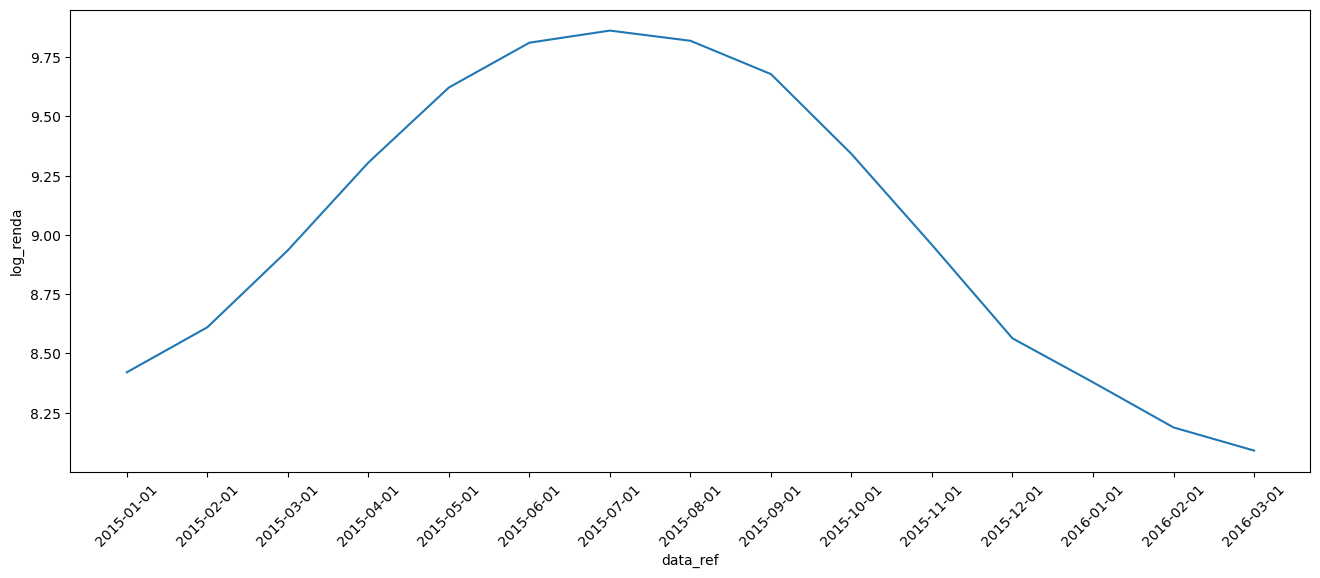

In [53]:
# Criando um gráfico de linha para mostrar a média de 'log_renda' ao longo do tempo (data_ref)

plt.figure(figsize=(16,6))  # Define o tamanho da figura

# Agrupa os dados de treino por 'data_ref' e calcula a média de 'renda_log' para cada data
sns.lineplot(data=df_train.groupby(by="data_ref").log_renda.mean())

# Rotaciona os rótulos do eixo x para que as datas fiquem mais legíveis
plt.xticks(rotation=45)

# Exibe o gráfico
plt.show()

In [57]:
# Ajustando 'log_renda' para remover a influência da variável 'data_ref'
# O objetivo é ajustar a variável 'log_renda' sem a influência de 'data_ref', conforme avaliado no gráfico anterior

df_train["log_renda_data_ref"] = df_train.log_renda - df_train.data_ref.map(df_train["log_renda"].groupby(by=df_train.data_ref).mean())

# Exibindo o DataFrame com a nova coluna 'renda_log_data_ref' que representa 'log_renda' ajustada
df_train

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,log_renda,lowess,leverage,student_resid,renda_log_data_ref,log_renda_data_ref
0,2016-02-01,15285,F,S,N,0,Empresário,Médio,Casado,Casa,51,18.295890,2.0,30153.21,10.314047,10.492502,0.001018,-0.125143,2.126037,2.126037
1,2015-06-01,481,M,S,S,0,Assalariado,Médio,Casado,Casa,60,4.441096,2.0,31267.83,10.350345,8.657608,0.000267,1.634691,0.539598,0.539598
2,2015-06-01,10942,F,N,N,0,Empresário,Médio,União,Casa,44,1.432877,2.0,6477.40,8.776074,8.270493,0.000673,0.542610,-1.034672,-1.034672
3,2015-01-01,6698,M,N,S,1,Servidor público,Médio,Casado,Casa,27,2.391781,3.0,1215.16,7.102631,8.399910,0.001376,-1.502955,-1.317837,-1.317837
4,2015-01-01,2515,F,N,S,0,Assalariado,Médio,Separado,Casa,49,24.301370,1.0,37628.57,10.535519,11.273907,0.001006,-0.775876,2.115050,2.115050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,2015-05-01,372,M,S,N,0,Assalariado,Superior completo,União,Aluguel,39,3.358904,2.0,10712.84,9.279198,8.528890,0.000408,0.910708,-0.342450,-0.342450
10496,2015-12-01,16000,F,N,S,0,Assalariado,Médio,Casado,Governamental,48,15.219178,2.0,5893.41,8.681590,10.066216,0.000397,-1.429907,0.117913,0.117913
10497,2015-02-01,675,M,S,S,0,Assalariado,Superior completo,Casado,Casa,28,6.112329,2.0,2086.27,7.643133,8.811644,0.000251,-1.222746,-0.967170,-0.967170
10498,2015-12-01,3704,M,S,N,0,Servidor público,Superior completo,Casado,Casa,27,5.268493,2.0,3384.15,8.126858,8.732885,0.001408,-0.590949,-0.436819,-0.436819


In [59]:
# Realizando uma nova regressão linear múltipla ajustada
# A variável dependente é 'log_renda_data_ref', que representa 'log_renda' ajustada para remover o efeito da 'data_ref'
# As variáveis independentes são: 'tempo_emprego', 'C(tipo_renda)' (variável categórica codificada como dummy), e 'C(posse_de_imovel)' (outra variável categórica codificada como dummy)

reg_ajuste = smf.ols(formula="log_renda_data_ref ~ tempo_emprego + C(tipo_renda) + C(posse_de_imovel)", data=df_train).fit()

# Exibindo o resumo dos resultados da nova regressão ajustada
reg_ajuste.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     log_renda_data_ref   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     2957.
Date:                Tue, 26 Nov 2024   Prob (F-statistic):               0.00
Time:                        15:07:19   Log-Likelihood:                -10161.
No. Observations:               10075   AIC:                         2.033e+04
Df Residuals:                   10069   BIC:                         2.038e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -1.1367      0.015    -73.403      0.000      -1.167      -1.106
C(tipo_renda)[T.Empresário]           0.1114      0.017      6.672      0.000       0.079       0.144
C(tipo_renda)[T.Pensionista]         -0.2893      0.018    -15.658      0.000      -0.326      -0.253
C(tipo_renda)[T.Servidor público]     0.1100      0.025      4.398      0.000       0.061       0.159
C(posse_de_imovel)[T.S]               0.2056      0.014     14.538      0.000       0.178       0.233
tempo_emprego                         0.1314      0.001    117.366      0.000       0.129       0.134
==============================================================================
Omnibus:                       37.451   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.937
Skew:                          -0.029   Prob(JB):                     5.20e-07
Kurtosis:                       2.744   Cond. No.                         39.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
# Calcula a média de 'log_renda' para cada 'data_ref' no DataFrame de treino
data_map = df_train.log_renda.groupby(df_train.data_ref).mean()

# Estima os valores de 'log_renda' para o DataFrame de teste
# Adiciona a previsão da regressão ajustada à média de 'log_renda' por 'data_ref'
log_renda_pred = df_test.data_ref.map(data_map) + reg_ajuste.predict(df_test)

# Calcula o coeficiente de determinação (R²) para avaliar o desempenho do modelo ajustado
r2 = r2_score(y_true=df_test.log_renda, y_pred=log_renda_pred)

# Exibe o R² como uma porcentagem
print("{:.2%}".format(r2))

67.61%
